# MLP

Following https://www.youtube.com/watch?v=TCH_1BHY58I&t=188s

# Rebuilding Dataset ( -  00:12:00)

- load dataset
- build character-index lookup table
- build (xxx) -> y dataset (as tensors)


In [1]:
from pathlib import Path
import torch

In [2]:
names = Path('../data/names.txt').open().read().splitlines()
names[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
characters = sorted(list(set(''.join(names))))
characters.insert(0, '.')

stoi = {c: i for i,c in enumerate(characters)}
itos = {i: c for c,i in stoi.items()}


In [4]:
from itertools import tee

def sliding_window(iterable, size):
    iters = tee(iterable, size)
    for i, it in enumerate(iters):
        for _ in range(i):
            next(it, None)
    return zip(*iters)


In [5]:
numbers = list(range(5))
for window in sliding_window(numbers, 3):
    print(window)

(0, 1, 2)
(1, 2, 3)
(2, 3, 4)


In [6]:
xs = []
ys = []
context_size = 3

for name in names[:5]:
    name = context_size*['.'] + list(name) + ['.']
    for chars in sliding_window(name, context_size+1):
        print(f'{chars[:context_size]} ---> {chars[-1]}')
        indices = list(map(lambda c: stoi[c], chars))
        xs.append((indices[:context_size]))
        ys.append(indices[-1])

xs = torch.tensor(xs)
ys = torch.tensor(ys)

('.', '.', '.') ---> e
('.', '.', 'e') ---> m
('.', 'e', 'm') ---> m
('e', 'm', 'm') ---> a
('m', 'm', 'a') ---> .
('.', '.', '.') ---> o
('.', '.', 'o') ---> l
('.', 'o', 'l') ---> i
('o', 'l', 'i') ---> v
('l', 'i', 'v') ---> i
('i', 'v', 'i') ---> a
('v', 'i', 'a') ---> .
('.', '.', '.') ---> a
('.', '.', 'a') ---> v
('.', 'a', 'v') ---> a
('a', 'v', 'a') ---> .
('.', '.', '.') ---> i
('.', '.', 'i') ---> s
('.', 'i', 's') ---> a
('i', 's', 'a') ---> b
('s', 'a', 'b') ---> e
('a', 'b', 'e') ---> l
('b', 'e', 'l') ---> l
('e', 'l', 'l') ---> a
('l', 'l', 'a') ---> .
('.', '.', '.') ---> s
('.', '.', 's') ---> o
('.', 's', 'o') ---> p
('s', 'o', 'p') ---> h
('o', 'p', 'h') ---> i
('p', 'h', 'i') ---> a
('h', 'i', 'a') ---> .


In [7]:
xs.shape

torch.Size([32, 3])

# Embedding Matrix ( - 00:18:00)

- Create Embedding Matrix with embedding size 2 (for now)

In [8]:
C = torch.randn((27,2), requires_grad=True)

# Hidden Layer ( - 00:29:00)

- Hidden layer of dimension (6, 100)
    - weights and biases
- Transform input from (batch_size, 3, embedding_size) to (batch_size, 3*embedding_size) to enable multiplication
- activation function: tanh


In [9]:
X = C[xs]
X.shape

torch.Size([32, 3, 2])

In [10]:
W = torch.randn((6,100), requires_grad=True)
b = torch.randn((1, 100), requires_grad=True)

In [11]:
batch_size = X.shape[0]
reshaped = X.view(batch_size, -1)
reshaped.shape


torch.Size([32, 6])

In [12]:
((reshaped @ W) + b).shape

torch.Size([32, 100])

In [13]:
activation = torch.tanh((reshaped @ W) + b)

# Output layer ( - 00:33:00)

- from hidden_size(100) to 27 (amount of characters)
- neg. likelihood like last notebook

## Last layer

In [14]:
activation.shape

torch.Size([32, 100])

In [15]:
W2 = torch.randn((100,27), requires_grad=True)
b2 = torch.randn(27, requires_grad=True)


In [16]:
output = (activation @ W2) + b2
output.shape

torch.Size([32, 27])

## Loss

In [17]:
import torch.nn.functional as F

From the documentation of [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss):

- input has to be a Tensor of size $(C)$ for unbatched input, $(minibatch, C)$ for batched input
- The target should be class indices in the range $[0, C)$ where $C$ is the number of classes
- Reduction is by default 'mean'

In [18]:
print('Input shape: ', output.shape)
print('Target shape: ', ys.shape)
print('Target values: ', ys)

Input shape:  torch.Size([32, 27])
Target shape:  torch.Size([32])
Target values:  tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])


In [19]:
F.cross_entropy(output, ys)

tensor(15.7781, grad_fn=<NllLossBackward0>)

Doing this by hand:

In [20]:
# softmax
counts = output.exp()
probs = counts / counts.sum(dim=1, keepdim=True)

# neg log likelihood
logs = - probs.log()
loss = logs[torch.arange(len(ys)), ys]
loss.mean()

tensor(15.7781, grad_fn=<MeanBackward0>)

# Refactoring ( - 00:38:00)

- Define all matrices in one place
- collect parameters in list
    - count parameters, should be 3481
- Use seed generator
- define forward pass with F.cross_entropy()

In [21]:
context_size = 3
embedding_size = 2
hidden_layer_size = 100
lr = .1

#### Dataset

In [22]:
xs = []
ys = []

for name in names[:5]:
    name = context_size*['.'] + list(name) + ['.']
    for chars in sliding_window(name, context_size+1):
        indices = list(map(lambda c: stoi[c], chars))
        xs.append((indices[:context_size]))
        ys.append(indices[-1])

xs = torch.tensor(xs)
ys = torch.tensor(ys)

xs.shape

torch.Size([32, 3])

#### NN Setup

In [23]:
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((27, embedding_size), requires_grad=True, generator=g)
W1 = torch.randn((embedding_size*context_size, hidden_layer_size), requires_grad=True, generator=g)
b1 = torch.randn(hidden_layer_size, requires_grad=True, generator=g)
W2 = torch.randn((hidden_layer_size, 27), requires_grad=True, generator=g)
b2 = torch.randn(27, requires_grad=True, generator=g)

parameters = [C, W1, b1, W2, b2]

print('Number of parameters: ', sum(p.nelement() for p in parameters))

Number of parameters:  3481


#### Forward pass

In [24]:
embeddings = C[xs].view(-1, embedding_size*context_size)

inner = torch.tanh((embeddings @ W1) + b1)
logits = (inner @ W2) + b2

loss = F.cross_entropy(logits, ys)
loss.item()

17.769710540771484

# Training loop ( - 00:45:00)

- forward pass
- backward pass
    - zero grads
    - update by learning rate
- repeat n times for the one batch (intentional overfitting)
    - loss should go to ~.25 (1000 iterations)
- comnpare logits max against ys (manually)
    - should be close to actual indices

- Train on full dataset
    - slow
- instead use minibatches of size 32
    - randomly drawn in each iteration

#### Train loop

In [25]:
for epoch in range(1000):
    # forward pass
    embeddings = C[xs].view(-1, embedding_size*context_size)

    inner = torch.tanh((embeddings @ W1) + b1)
    logits = (inner @ W2) + b2

    loss = F.cross_entropy(logits, ys)

    # backward pass
    for param in parameters:
        param.grad = None

    loss.backward()

    # optimization

    for param in parameters:
        param.data -= lr * param.grad

    if epoch%100==0:
        print(loss.item())

17.769710540771484
0.3354488015174866
0.278947651386261
0.2678886950016022
0.2631761431694031
0.26341554522514343
0.2601673901081085
0.2586156725883484
0.2575641870498657
0.256767600774765


#### Compare logits against indices

In [26]:
logits.max(dim=1)

torch.return_types.max(
values=tensor([13.3348, 17.7904, 20.6014, 20.6121, 16.7355, 13.3348, 15.9984, 14.1723,
        15.9146, 18.3614, 15.9395, 20.9265, 13.3348, 17.1090, 17.1319, 20.0601,
        13.3348, 16.5892, 15.1017, 17.0581, 18.5861, 15.9670, 10.8740, 10.6871,
        15.5056, 13.3348, 16.1794, 16.9743, 12.7426, 16.2009, 19.0845, 16.0195],
       grad_fn=<MaxBackward0>),
indices=tensor([19, 13, 13,  1,  0, 19, 12,  9, 22,  9,  1,  0, 19, 22,  1,  0, 19, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0]))

In [27]:
ys

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

#### Train on full dataset

In [28]:
xs = []
ys = []

for name in names:
    name = context_size*['.'] + list(name) + ['.']
    for chars in sliding_window(name, context_size+1):
        indices = list(map(lambda c: stoi[c], chars))
        xs.append((indices[:context_size]))
        ys.append(indices[-1])

xs = torch.tensor(xs)
ys = torch.tensor(ys)

xs.shape

torch.Size([228146, 3])

In [29]:
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((27, embedding_size), requires_grad=True, generator=g)
W1 = torch.randn((embedding_size*context_size, hidden_layer_size), requires_grad=True, generator=g)
b1 = torch.randn(hidden_layer_size, requires_grad=True, generator=g)
W2 = torch.randn((hidden_layer_size, 27), requires_grad=True, generator=g)
b2 = torch.randn(27, requires_grad=True, generator=g)

parameters = [C, W1, b1, W2, b2]

print('Number of parameters: ', sum(p.nelement() for p in parameters))

Number of parameters:  3481


In [30]:
for epoch in range(10):
    # forward pass
    embeddings = C[xs].view(-1, embedding_size*context_size)

    inner = torch.tanh((embeddings @ W1) + b1)
    logits = (inner @ W2) + b2

    loss = F.cross_entropy(logits, ys)

    # backward pass
    for param in parameters:
        param.grad = None

    loss.backward()

    # optimization

    for param in parameters:
        param.data -= lr * param.grad

    print(loss.item())

19.505229949951172
17.084495544433594
15.776532173156738
14.833337783813477
14.002595901489258
13.253252983093262
12.579911231994629
11.9830961227417
11.470491409301758
11.051857948303223


#### Minibatches

In [31]:
batch_size = 32

In [32]:
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((27, embedding_size), requires_grad=True, generator=g)
W1 = torch.randn((embedding_size*context_size, hidden_layer_size), requires_grad=True, generator=g)
b1 = torch.randn(hidden_layer_size, requires_grad=True, generator=g)
W2 = torch.randn((hidden_layer_size, 27), requires_grad=True, generator=g)
b2 = torch.randn(27, requires_grad=True, generator=g)

parameters = [C, W1, b1, W2, b2]

print('Number of parameters: ', sum(p.nelement() for p in parameters))

Number of parameters:  3481


In [33]:
lr = 1e-1

In [34]:
for epoch in range(1000):

    rand_idx = torch.multinomial(torch.ones(len(xs)), num_samples=batch_size, replacement=True)
    xb = xs[rand_idx]
    yb = ys[rand_idx]

    # forward pass
    embeddings = C[xb].view(-1, embedding_size*context_size)

    inner = torch.tanh((embeddings @ W1) + b1)
    logits = (inner @ W2) + b2

    loss = F.cross_entropy(logits, yb)

    # backward pass
    for param in parameters:
        param.grad = None

    loss.backward()

    # optimization

    for param in parameters:
        param.data -= lr * param.grad

print(loss.item())

2.536257266998291


In [35]:
with torch.no_grad():
    embeddings = C[xs].view(-1, embedding_size*context_size)

    inner = torch.tanh((embeddings @ W1) + b1)
    logits = (inner @ W2) + b2

    loss = F.cross_entropy(logits, ys)
    print(loss.item())

2.7020065784454346


# Learning Rate finder (  - 00:53:00)

- reset all parameters
- print loss for each batch
    - find too low lr
    - find too high lr
- generate log lrs between low and high end
- plot loss against lr
- choose lr at hockey stick point

In [56]:
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((27, embedding_size), requires_grad=True, generator=g)
W1 = torch.randn((embedding_size*context_size, hidden_layer_size), requires_grad=True, generator=g)
b1 = torch.randn(hidden_layer_size, requires_grad=True, generator=g)
W2 = torch.randn((hidden_layer_size, 27), requires_grad=True, generator=g)
b2 = torch.randn(27, requires_grad=True, generator=g)

parameters = [C, W1, b1, W2, b2]

print('Number of parameters: ', sum(p.nelement() for p in parameters))

Number of parameters:  3481


In [57]:
# too high: 10e2
# too low: 1e-3

lrs = torch.linspace(-3, 0, 100)
losses = []

for lr in lrs:

    rand_idx = torch.multinomial(torch.ones(len(xs)), num_samples=batch_size, replacement=True)
    xb = xs[rand_idx]
    yb = ys[rand_idx]

    # forward pass
    embeddings = C[xb].view(-1, embedding_size*context_size)

    inner = torch.tanh((embeddings @ W1) + b1)
    logits = (inner @ W2) + b2

    loss = F.cross_entropy(logits, yb)

    # backward pass
    for param in parameters:
        param.grad = None

    loss.backward()

    # optimization

    for param in parameters:
        param.data -= (10**lr) * param.grad

    losses.append(loss.item())
    print(loss.item())

20.559709548950195
15.81920337677002
21.557371139526367
19.788726806640625
15.139687538146973
22.96284294128418
17.153684616088867
19.712646484375
19.57217788696289
18.848974227905273
19.81866455078125
17.85858726501465
19.368131637573242
19.746456146240234
15.742476463317871
20.083404541015625
19.687341690063477
20.555767059326172
16.42055320739746
18.437522888183594
19.33500099182129
22.48651885986328
18.883277893066406
18.281208038330078
14.829050064086914
18.259044647216797
18.10097312927246
16.54646873474121
19.82721710205078
17.472270965576172
16.401887893676758
17.38470458984375
16.8785343170166
13.509093284606934
16.83677864074707
16.70842933654785
15.996024131774902
14.194262504577637
16.20220184326172
17.753787994384766
18.45462989807129
16.067129135131836
15.203129768371582
14.943780899047852
14.149185180664062
12.091032028198242
15.469017028808594
16.287094116210938
17.327438354492188
11.473048210144043
14.161043167114258
12.4132080078125
13.349205017089844
12.8978719711303

In [58]:
import matplotlib.pyplot as plt

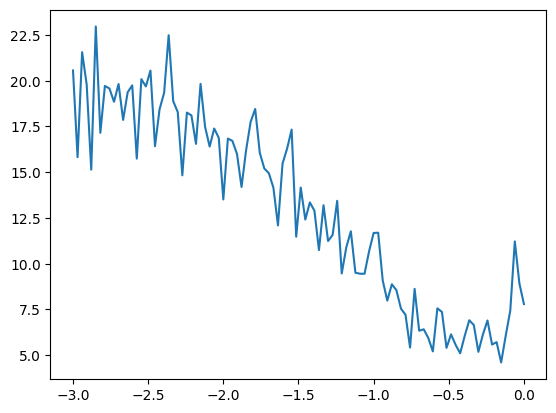

In [59]:
fix, ax = plt.subplots()

ax.plot(lrs, losses)

plt.show()

# Overfitting

- split into training/dev/test set
  - e.g. $80\%$ / $10\%$ / $10\%$
  - train: tune parameters
  - dev: hyperparameters
  - test: actual model performance. Evaluate only sparingly, as every evaluation makes overfitting more likely
- shuffle all words with seed 42 (with python random)
- take first $80\%$ for train, next $10\%$ for dev
- evaluate
  - train on train set
  - evaluate on dev set
  - 30k iterations, should be roughly equal loss
- Overfitting can't really happen right now, because model is too small
- make model larger
  - increase hidden layer size to $300$
  - plot loss over steps
    - very noisy
  - decrease learning rate
  - retrain until loss is smaller than with smaller model
- visualize character embeddings
- increase net once again:
  - emb_size=10
  - decrease hidden from 300 to 200
- plot log-loss over steps
- sample from the model
- read the [original paper](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)